# Investigating steps in timeseries of SSH gradient
- see https://github.com/COSIMA/access-om2/issues/243 and https://arccss.slack.com/archives/C6PP0GU9Y/p1614235878023200
- calculating timeseries took over a day and repeatedly ran out of memory even when run with `gadi_jupyter -P v45 -t 15:00:00 -n 20 -m 190Gb`

In [1]:
import cosima_cookbook as cc
from dask.distributed import Client
from glob import glob
import csv
import os,sys
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr
# import netCDF4 as nc
# from tqdm import tqdm_notebook
import cartopy.crs as ccrs
import cartopy.feature as cft
#from mpl_toolkits.basemap import Basemap
# from calendar import month_abbr
import cmocean as cm
# import pandas as pd
# import calendar
# import cftime
# from datetime import timedelta
# from datetime import datetime
import datetime
# import copy
# import xesmf
import dateutil.parser

In [2]:
import climtas.nci
climtas.nci.GadiClient()

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: /proxy/8787/status,
Status: running,Using processes: True
Dashboard: /proxy/8787/status,Workers: 20
Total threads: 20,Total memory: 190.00 GiB
Comm: tcp://127.0.0.1:37611,Workers: 20
Dashboard: /proxy/8787/status,Total threads: 20
Started: Just now,Total memory: 190.00 GiB
Comm: tcp://127.0.0.1:39199,Total threads: 1
Dashboard: /proxy/41231/status,Memory: 9.50 GiB
Nanny: tcp://127.0.0.1:40495,


In [3]:
session = cc.database.create_session()

In [4]:
expts = [ '01deg_jra55v140_iaf', '01deg_jra55v140_iaf_cycle2', '01deg_jra55v140_iaf_cycle3' ]

## Open run summaries for timestep changes
see https://github.com/aekiss/notebooks/blob/master/run_summary.ipynb

In [5]:
summaries = { e: glob('/home/156/aek156/payu/'+e+'/run_summary_*'+e+'.csv')[0] for e in expts }

In [6]:
summaries

{'01deg_jra55v140_iaf': '/home/156/aek156/payu/01deg_jra55v140_iaf/run_summary_home_156_aek156_payu_01deg_jra55v140_iaf.csv',
 '01deg_jra55v140_iaf_cycle2': '/home/156/aek156/payu/01deg_jra55v140_iaf_cycle2/run_summary_home_156_aek156_payu_01deg_jra55v140_iaf_cycle2.csv',
 '01deg_jra55v140_iaf_cycle3': '/home/156/aek156/payu/01deg_jra55v140_iaf_cycle3/run_summary_home_156_aek156_payu_01deg_jra55v140_iaf_cycle3.csv'}

In [7]:
def num(s):
    try:
        return int(s)
    except ValueError:
        try:
            return float(s)
        except ValueError:
            try:
                return dateutil.parser.parse(s)       
            except ValueError:
                if len(s) == 0:
                    return None
                else:
                    return s

In [8]:
# read run summaries
prefixlen = len(os.path.commonpath(summaries))+1
alldata = dict()
for expt, f in summaries.items():
    with open(f) as csvfile:
        rows = csv.reader(csvfile)
        row1 = next(rows)
        if row1[0] == 'Summary report generated by run_summary.py, https://github.com/aekiss/run_summary':
            for i in range(3):  # assume column headings are in row 5
                next(rows)
            colnames = next(rows)
        else:  # assume column headings are in row 1
            colnames = row1
        data = dict([(key, []) for key in colnames])
        for drow in csv.DictReader(csvfile, colnames):
            if max([len(v) for v in drow.values()]) == 0:
                break  # exit at blank row at end of data, to skip stats
            for k,v in data.items():                
                v.append(num(drow[k]))
#     alldata[f[prefixlen:].split('run_summary_',1)[1].split('.csv',1)[0]] = data
    alldata[expt] = data

In [9]:
changeidx = {k:np.where(np.array(v['Timestep (s)'])[:-1] != np.array(v['Timestep (s)'])[1:])[0] for k,v in alldata.items()}

In [10]:
changeidx

{'01deg_jra55v140_iaf': array([  1,   4,   9,  10,  98,  99, 121, 122, 130, 131, 137, 138, 150,
        151, 198, 199, 209, 210]),
 '01deg_jra55v140_iaf_cycle2': array([ 53,  54,  98,  99, 121, 122, 130, 131, 209, 210]),
 '01deg_jra55v140_iaf_cycle3': array([ 98,  99, 119, 120, 121, 122, 150, 151, 198, 199, 209, 210, 235,
        236])}

In [11]:
{k:[(i, v['Run start'][i], v['Timestep (s)'][i], v['Timestep (s)'][i+1]) for i in changeidx[k]] for k,v in alldata.items()}

{'01deg_jra55v140_iaf': [(1, datetime.datetime(1958, 4, 1, 0, 0), 300, 400),
  (4, datetime.datetime(1959, 1, 1, 0, 0), 400, 540),
  (9, datetime.datetime(1960, 4, 1, 0, 0), 540, 450),
  (10, datetime.datetime(1960, 7, 1, 0, 0), 450, 540),
  (98, datetime.datetime(1982, 7, 1, 0, 0), 540, 400),
  (99, datetime.datetime(1982, 10, 1, 0, 0), 400, 540),
  (121, datetime.datetime(1988, 4, 1, 0, 0), 540, 360),
  (122, datetime.datetime(1988, 7, 1, 0, 0), 360, 540),
  (130, datetime.datetime(1990, 7, 1, 0, 0), 540, 360),
  (131, datetime.datetime(1990, 10, 1, 0, 0), 360, 540),
  (137, datetime.datetime(1992, 4, 1, 0, 0), 540, 360),
  (138, datetime.datetime(1992, 7, 1, 0, 0), 360, 540),
  (150, datetime.datetime(1995, 7, 1, 0, 0), 540, 360),
  (151, datetime.datetime(1995, 10, 1, 0, 0), 360, 540),
  (198, datetime.datetime(2007, 7, 1, 0, 0), 540, 360),
  (199, datetime.datetime(2007, 10, 1, 0, 0), 360, 540),
  (209, datetime.datetime(2010, 4, 1, 0, 0), 540, 360),
  (210, datetime.datetime(2010

## Calculate daily mean ssh slope metric

In [12]:
variable = 'sea_level'
frequency = '1 daily'
attrs = None
# attrs = {'cell_methods': 'time: mean'}

### Check correct files are loaded
- this confirms steps are not due to this cookbook bug https://github.com/COSIMA/cosima-cookbook/issues/252

In [13]:
# from https://github.com/COSIMA/cosima-cookbook/issues/252#issue-951322001
files = list()
for expt in expts:
    try:
        info = cc.querying._ncfiles_for_variable(expt, variable, session, frequency=frequency, attrs=attrs)
        files += [str(f.NCFile.ncfile_path) for f in info]
    except: # 'VariableNotFoundError':
        pass
files
[f for f in files if not ('mean' in f)]

[]

In [14]:
files

['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output000/ocean/ocean-2d-sea_level-1-daily-mean-ym_1958_01.nc',
 '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output001/ocean/ocean-2d-sea_level-1-daily-mean-ym_1958_04.nc',
 '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output002/ocean/ocean-2d-sea_level-1-daily-mean-ym_1958_07.nc',
 '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output003/ocean/ocean-2d-sea_level-1-daily-mean-ym_1958_10.nc',
 '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output004/ocean/ocean-2d-sea_level-1-daily-mean-ym_1959_01.nc',
 '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output005/ocean/ocean-2d-sea_level-1-daily-mean-ym_1959_04.nc',
 '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output006/ocean/ocean-2d-sea_level-1-daily-mean-ym_1959_07.nc',
 '/g/data/cj50/access-om2/raw-output/access-om2-01/01de

### pre-calculate data
- took over a day and repeatedly ran out of memory even when run with `gadi_jupyter -P v45 -t 15:00:00 -n 20 -m 190Gb`
- data cached in `/g/data/v45/aek156/notebooks/github/aekiss/notebooks/ssh_gradient_timeseries_steps`

In [15]:
for yr in range(1958, 2019):
    start_time = '-'.join([str(yr), '01', '01'])
    end_time = '-'.join([str(yr+1), '01', '01'])
    for k in expts:
        p = '_'.join([k, variable, 'diffsq', 'sum', start_time, end_time])+'.nc'
        if not os.path.exists(p):
            print('calculating and saving', p)
            sea_level = cc.querying.getvar(expt=k, variable=variable, 
                              session=session, frequency=frequency,
                              start_time=start_time,
                              end_time=end_time).sel(time=slice(start_time, end_time))
            sea_level_xdiff = sea_level.diff('xt_ocean')
            sea_level_ydiff = sea_level.diff('yt_ocean')
            del sea_level
            sea_level_diffsq = sea_level_xdiff.isel(yt_ocean=slice(0, -1))**2 \
                             + sea_level_ydiff.isel(xt_ocean=slice(0, -1))**2
            del sea_level_xdiff
            del sea_level_ydiff
            sea_level_diffsq_sum = sea_level_diffsq.sum('xt_ocean').sum('yt_ocean')
            del sea_level_diffsq
            sea_level_diffsq_sum.compute()
            sea_level_diffsq_sum.to_netcdf(p)
            del sea_level_diffsq_sum
        else:
            print(' --- skipping', p, '(file exists)')

 --- skipping 01deg_jra55v140_iaf_sea_level_diffsq_sum_1958-01-01_1959-01-01.nc (file exists)
 --- skipping 01deg_jra55v140_iaf_cycle2_sea_level_diffsq_sum_1958-01-01_1959-01-01.nc (file exists)
 --- skipping 01deg_jra55v140_iaf_cycle3_sea_level_diffsq_sum_1958-01-01_1959-01-01.nc (file exists)
 --- skipping 01deg_jra55v140_iaf_sea_level_diffsq_sum_1959-01-01_1960-01-01.nc (file exists)
 --- skipping 01deg_jra55v140_iaf_cycle2_sea_level_diffsq_sum_1959-01-01_1960-01-01.nc (file exists)
 --- skipping 01deg_jra55v140_iaf_cycle3_sea_level_diffsq_sum_1959-01-01_1960-01-01.nc (file exists)
 --- skipping 01deg_jra55v140_iaf_sea_level_diffsq_sum_1960-01-01_1961-01-01.nc (file exists)
 --- skipping 01deg_jra55v140_iaf_cycle2_sea_level_diffsq_sum_1960-01-01_1961-01-01.nc (file exists)
 --- skipping 01deg_jra55v140_iaf_cycle3_sea_level_diffsq_sum_1960-01-01_1961-01-01.nc (file exists)
 --- skipping 01deg_jra55v140_iaf_sea_level_diffsq_sum_1961-01-01_1962-01-01.nc (file exists)
 --- skipping 01de

### load pre-calculated data

In [16]:
sea_levels_diffsq_sum = dict()
for k in expts:
    dsets = list()
    prefix = '_'.join([k, variable, 'diffsq', 'sum'])
    files = glob(prefix+'_*.nc')
    files.sort()
    for f in files:
        # need to slice time, as some files are longer than they should be
        fdates = f[len(prefix):].split('_')[1:]
        timeslice = slice(fdates[0], fdates[1].split('.')[0])
        ds = xr.open_dataset(f)[variable]
        ds = ds.sel(time=timeslice)
# print warning if ds is all nans
        if ds.sum().data == 0:
            print('rm', f)
        if len(ds.dropna('time')) == 0:
            print('rm', f)
        dsets.append(ds)
    sea_levels_diffsq_sum[k] = xr.concat(dsets, 'time')

In [17]:
{k:[v['Run start'][i] for i in changeidx[k]] for k,v in alldata.items()}

{'01deg_jra55v140_iaf': [datetime.datetime(1958, 4, 1, 0, 0),
  datetime.datetime(1959, 1, 1, 0, 0),
  datetime.datetime(1960, 4, 1, 0, 0),
  datetime.datetime(1960, 7, 1, 0, 0),
  datetime.datetime(1982, 7, 1, 0, 0),
  datetime.datetime(1982, 10, 1, 0, 0),
  datetime.datetime(1988, 4, 1, 0, 0),
  datetime.datetime(1988, 7, 1, 0, 0),
  datetime.datetime(1990, 7, 1, 0, 0),
  datetime.datetime(1990, 10, 1, 0, 0),
  datetime.datetime(1992, 4, 1, 0, 0),
  datetime.datetime(1992, 7, 1, 0, 0),
  datetime.datetime(1995, 7, 1, 0, 0),
  datetime.datetime(1995, 10, 1, 0, 0),
  datetime.datetime(2007, 7, 1, 0, 0),
  datetime.datetime(2007, 10, 1, 0, 0),
  datetime.datetime(2010, 4, 1, 0, 0),
  datetime.datetime(2010, 7, 1, 0, 0)],
 '01deg_jra55v140_iaf_cycle2': [datetime.datetime(1971, 4, 1, 0, 0),
  datetime.datetime(1971, 7, 1, 0, 0),
  datetime.datetime(1982, 7, 1, 0, 0),
  datetime.datetime(1982, 10, 1, 0, 0),
  datetime.datetime(1988, 4, 1, 0, 0),
  datetime.datetime(1988, 7, 1, 0, 0),
  dat

## Make plot

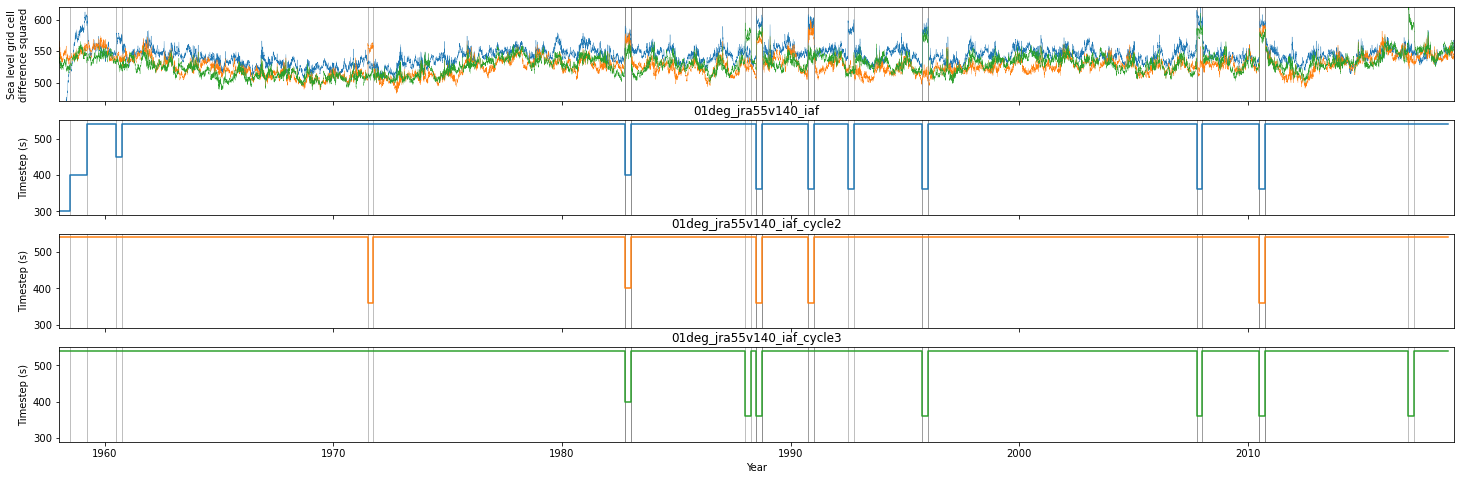

In [18]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # default color cycle
changedates = {k:[v['Run start'][i+1] for i in changeidx[k]] for k,v in alldata.items()}
dates = {k:v['Run start'] for k,v in alldata.items()}
timesteps = {k:v['Timestep (s)'] for k,v in alldata.items()}
# dates = {k:v.append(v[-1]) for k,v in dates.items()}
# timesteps = {k:v.append(v[-1]) for k,v in timesteps.items()}
plt.figure(figsize=(25,8))

for k,v in sea_levels_diffsq_sum.items():
    for p in range(1, 5):
        plt.subplot(4,1,p)
        for idx in changedates[k]:
    #         plt.axvline(idx, ymin=i*0.05, ymax=(i+0.7)*0.05, color=colors[i], linewidth=3)
            plt.axvline(idx, ymin=0, ymax=1, color='gray', linewidth=.5)

plt.subplot(4,1,1)

for i, (k,v) in enumerate(sea_levels_diffsq_sum.items()):
#     for idx in changedates[k]:
# #         plt.axvline(idx, ymin=i*0.05, ymax=(i+0.7)*0.05, color=colors[i], linewidth=3)
#         plt.axvline(idx, ymin=0, ymax=1, color='k', linewidth=1)
    v.plot(label=k, linewidth=0.3, color=colors[i])
#     plt.plot(dates[k], timesteps[k], color=colors[i], drawstyle='steps-post')
#     plt.legend()
    plt.ylabel("Sea level grid cell\ndifference squared")
#     plt.xlim(['1958-01-01', '2019-01-01'])
    plt.ylim([470, 620])
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.xlabel('')
    plt.xlim([datetime.date(1958, 1, 1), datetime.date(2019, 1, 1)])
    xaxlim = plt.gca().get_xlim()

for i, (k,v) in enumerate(sea_levels_diffsq_sum.items()):
    plt.subplot(4,1,i+2)
    plt.plot(dates[k], timesteps[k], color=colors[i], drawstyle='steps-post')
#     plt.legend()
    plt.title(k)
    plt.ylim([290, 550])
    plt.ylabel("Timestep (s)")
    if i < 2:
        plt.gca().axes.xaxis.set_ticklabels([])
        plt.xlabel('')
    else:
        plt.xlabel('Year')
    plt.xlim(xaxlim)

plt.savefig('ssh_gradient_timeseries.png', dpi=200)

    
#     for idx in changedates[k]:
#         plt.axvline(idx, ymin=i*0.05, ymax=(i+0.7)*0.05, color=colors[i], linewidth=3)
#         plt.axvline(idx, ymin=0, ymax=1, color='k', linewidth=1)
#     v.plot(label=k, linewidth=0.3, color=colors[i])


## Calculate monthly mean ssh slope metric

In [19]:
variable = 'sea_level'
frequency = '1 monthly'
# attrs = None
attrs = {'cell_methods': 'time: mean'}

### Check correct files are loaded
- get a mix of mean and snap if attrs=None due to this cookbook bug https://github.com/COSIMA/cosima-cookbook/issues/252

In [21]:
# from https://github.com/COSIMA/cosima-cookbook/issues/252#issue-951322001
files = list()
for expt in expts:
    try:
        info = cc.querying._ncfiles_for_variable(expt, variable, session, frequency=frequency, attrs=attrs)
#         info = cc.querying._ncfiles_for_variable(expt, variable, session, frequency=frequency)
        files += [str(f.NCFile.ncfile_path) for f in info]
    except: # 'VariableNotFoundError':
        pass
files
[f for f in files if not ('mean' in f)]

[]

In [22]:
files

['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output000/ocean/ocean-2d-sea_level-1-monthly-mean-ym_1958_01.nc',
 '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output001/ocean/ocean-2d-sea_level-1-monthly-mean-ym_1958_04.nc',
 '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output002/ocean/ocean-2d-sea_level-1-monthly-mean-ym_1958_07.nc',
 '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output003/ocean/ocean-2d-sea_level-1-monthly-mean-ym_1958_10.nc',
 '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output004/ocean/ocean-2d-sea_level-1-monthly-mean-ym_1959_01.nc',
 '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output005/ocean/ocean-2d-sea_level-1-monthly-mean-ym_1959_04.nc',
 '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output006/ocean/ocean-2d-sea_level-1-monthly-mean-ym_1959_07.nc',
 '/g/data/cj50/access-om2/raw-output/acce

### pre-calculate data
- took over a day and repeatedly ran out of memory even when run with `gadi_jupyter -P v45 -t 15:00:00 -n 20 -m 190Gb`
- data cached in `/g/data/v45/aek156/notebooks/github/aekiss/notebooks/ssh_gradient_timeseries_steps`

In [25]:
for yr in range(1958, 2019):
    start_time = '-'.join([str(yr), '01', '01'])
    end_time = '-'.join([str(yr+1), '01', '01'])
    for k in expts:
        p = '_'.join([k, variable, frequency.replace(' ','-'), attrs['cell_methods'].split(': ')[1], 'diffsq', 'sum', start_time, end_time])+'.nc'
        if not os.path.exists(p):
            print('calculating and saving', p)
            sea_level = cc.querying.getvar(expt=k, variable=variable, 
                              session=session, frequency=frequency, attrs=attrs,
                              start_time=start_time,
                              end_time=end_time).sel(time=slice(start_time, end_time))
            sea_level_xdiff = sea_level.diff('xt_ocean')
            sea_level_ydiff = sea_level.diff('yt_ocean')
            del sea_level
            sea_level_diffsq = sea_level_xdiff.isel(yt_ocean=slice(0, -1))**2 \
                             + sea_level_ydiff.isel(xt_ocean=slice(0, -1))**2
            del sea_level_xdiff
            del sea_level_ydiff
            sea_level_diffsq_sum = sea_level_diffsq.sum('xt_ocean').sum('yt_ocean')
            del sea_level_diffsq
            sea_level_diffsq_sum.compute()
            sea_level_diffsq_sum.to_netcdf(p)
            del sea_level_diffsq_sum
        else:
            print(' --- skipping', p, '(file exists)')

calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1958-01-01_1959-01-01.nc
calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1958-01-01_1959-01-01.nc
calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1958-01-01_1959-01-01.nc
calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1959-01-01_1960-01-01.nc
calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1959-01-01_1960-01-01.nc
calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1959-01-01_1960-01-01.nc
calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1960-01-01_1961-01-01.nc
calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1960-01-01_1961-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1960-01-01_1961-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1961-01-01_1962-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1961-01-01_1962-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1961-01-01_1962-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1962-01-01_1963-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1962-01-01_1963-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1962-01-01_1963-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1963-01-01_1964-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1963-01-01_1964-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1963-01-01_1964-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1964-01-01_1965-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1964-01-01_1965-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1964-01-01_1965-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1965-01-01_1966-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1965-01-01_1966-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1965-01-01_1966-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1966-01-01_1967-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1966-01-01_1967-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1966-01-01_1967-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1967-01-01_1968-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1967-01-01_1968-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1967-01-01_1968-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1968-01-01_1969-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1968-01-01_1969-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1968-01-01_1969-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1969-01-01_1970-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1969-01-01_1970-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1969-01-01_1970-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1970-01-01_1971-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1970-01-01_1971-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1970-01-01_1971-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1971-01-01_1972-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1971-01-01_1972-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1971-01-01_1972-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1972-01-01_1973-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1972-01-01_1973-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1972-01-01_1973-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1973-01-01_1974-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1973-01-01_1974-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1973-01-01_1974-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1974-01-01_1975-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1974-01-01_1975-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1974-01-01_1975-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1975-01-01_1976-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1975-01-01_1976-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1975-01-01_1976-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1976-01-01_1977-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1976-01-01_1977-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1976-01-01_1977-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1977-01-01_1978-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1977-01-01_1978-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1977-01-01_1978-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1978-01-01_1979-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1978-01-01_1979-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1978-01-01_1979-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1979-01-01_1980-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1979-01-01_1980-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1979-01-01_1980-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1980-01-01_1981-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1980-01-01_1981-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1980-01-01_1981-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1981-01-01_1982-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1981-01-01_1982-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1981-01-01_1982-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1982-01-01_1983-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1982-01-01_1983-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1982-01-01_1983-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1983-01-01_1984-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1983-01-01_1984-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1983-01-01_1984-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1984-01-01_1985-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1984-01-01_1985-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1984-01-01_1985-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1985-01-01_1986-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1985-01-01_1986-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1985-01-01_1986-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1986-01-01_1987-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1986-01-01_1987-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1986-01-01_1987-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1987-01-01_1988-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1987-01-01_1988-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1987-01-01_1988-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1988-01-01_1989-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1988-01-01_1989-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1988-01-01_1989-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1989-01-01_1990-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1989-01-01_1990-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1989-01-01_1990-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1990-01-01_1991-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1990-01-01_1991-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1990-01-01_1991-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1991-01-01_1992-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1991-01-01_1992-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1991-01-01_1992-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1992-01-01_1993-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1992-01-01_1993-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1992-01-01_1993-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1993-01-01_1994-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1993-01-01_1994-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1993-01-01_1994-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1994-01-01_1995-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1994-01-01_1995-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1994-01-01_1995-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1995-01-01_1996-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1995-01-01_1996-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1995-01-01_1996-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1996-01-01_1997-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1996-01-01_1997-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1996-01-01_1997-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1997-01-01_1998-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1997-01-01_1998-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1997-01-01_1998-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1998-01-01_1999-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1998-01-01_1999-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1998-01-01_1999-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_1999-01-01_2000-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_1999-01-01_2000-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_1999-01-01_2000-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_2000-01-01_2001-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_2000-01-01_2001-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_2000-01-01_2001-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_2001-01-01_2002-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_2001-01-01_2002-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_2001-01-01_2002-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_2002-01-01_2003-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_2002-01-01_2003-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_2002-01-01_2003-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_2003-01-01_2004-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_2003-01-01_2004-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_2003-01-01_2004-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_2004-01-01_2005-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_2004-01-01_2005-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_2004-01-01_2005-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_2005-01-01_2006-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_2005-01-01_2006-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_2005-01-01_2006-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_2006-01-01_2007-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_2006-01-01_2007-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_2006-01-01_2007-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_2007-01-01_2008-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_2007-01-01_2008-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_2007-01-01_2008-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_2008-01-01_2009-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_2008-01-01_2009-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_2008-01-01_2009-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_2009-01-01_2010-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_2009-01-01_2010-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_2009-01-01_2010-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_2010-01-01_2011-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_2010-01-01_2011-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_2010-01-01_2011-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_2011-01-01_2012-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_2011-01-01_2012-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_2011-01-01_2012-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_2012-01-01_2013-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_2012-01-01_2013-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_2012-01-01_2013-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_2013-01-01_2014-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_2013-01-01_2014-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_2013-01-01_2014-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_2014-01-01_2015-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_2014-01-01_2015-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_2014-01-01_2015-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_2015-01-01_2016-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_2015-01-01_2016-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_2015-01-01_2016-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_2016-01-01_2017-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_2016-01-01_2017-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_2016-01-01_2017-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_2017-01-01_2018-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_2017-01-01_2018-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_2017-01-01_2018-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_sea_level_1-monthly_mean_diffsq_sum_2018-01-01_2019-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle2_sea_level_1-monthly_mean_diffsq_sum_2018-01-01_2019-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


calculating and saving 01deg_jra55v140_iaf_cycle3_sea_level_1-monthly_mean_diffsq_sum_2018-01-01_2019-01-01.nc


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


### load pre-calculated data

In [26]:
sea_levels_diffsq_sum = dict()
for k in expts:
    dsets = list()
    prefix = '_'.join([k, variable, frequency.replace(' ','-'), attrs['cell_methods'].split(': ')[1], 'diffsq', 'sum'])
    files = glob(prefix+'_*.nc')
    files.sort()
    for f in files:
        # need to slice time, as some files are longer than they should be
        fdates = f[len(prefix):].split('_')[1:]
        timeslice = slice(fdates[0], fdates[1].split('.')[0])
        ds = xr.open_dataset(f)[variable]
        ds = ds.sel(time=timeslice)
# print warning if ds is all nans
        if ds.sum().data == 0:
            print('rm', f)
        if len(ds.dropna('time')) == 0:
            print('rm', f)
        dsets.append(ds)
    sea_levels_diffsq_sum[k] = xr.concat(dsets, 'time')

In [27]:
{k:[v['Run start'][i] for i in changeidx[k]] for k,v in alldata.items()}

{'01deg_jra55v140_iaf': [datetime.datetime(1958, 4, 1, 0, 0),
  datetime.datetime(1959, 1, 1, 0, 0),
  datetime.datetime(1960, 4, 1, 0, 0),
  datetime.datetime(1960, 7, 1, 0, 0),
  datetime.datetime(1982, 7, 1, 0, 0),
  datetime.datetime(1982, 10, 1, 0, 0),
  datetime.datetime(1988, 4, 1, 0, 0),
  datetime.datetime(1988, 7, 1, 0, 0),
  datetime.datetime(1990, 7, 1, 0, 0),
  datetime.datetime(1990, 10, 1, 0, 0),
  datetime.datetime(1992, 4, 1, 0, 0),
  datetime.datetime(1992, 7, 1, 0, 0),
  datetime.datetime(1995, 7, 1, 0, 0),
  datetime.datetime(1995, 10, 1, 0, 0),
  datetime.datetime(2007, 7, 1, 0, 0),
  datetime.datetime(2007, 10, 1, 0, 0),
  datetime.datetime(2010, 4, 1, 0, 0),
  datetime.datetime(2010, 7, 1, 0, 0)],
 '01deg_jra55v140_iaf_cycle2': [datetime.datetime(1971, 4, 1, 0, 0),
  datetime.datetime(1971, 7, 1, 0, 0),
  datetime.datetime(1982, 7, 1, 0, 0),
  datetime.datetime(1982, 10, 1, 0, 0),
  datetime.datetime(1988, 4, 1, 0, 0),
  datetime.datetime(1988, 7, 1, 0, 0),
  dat

## Make plot

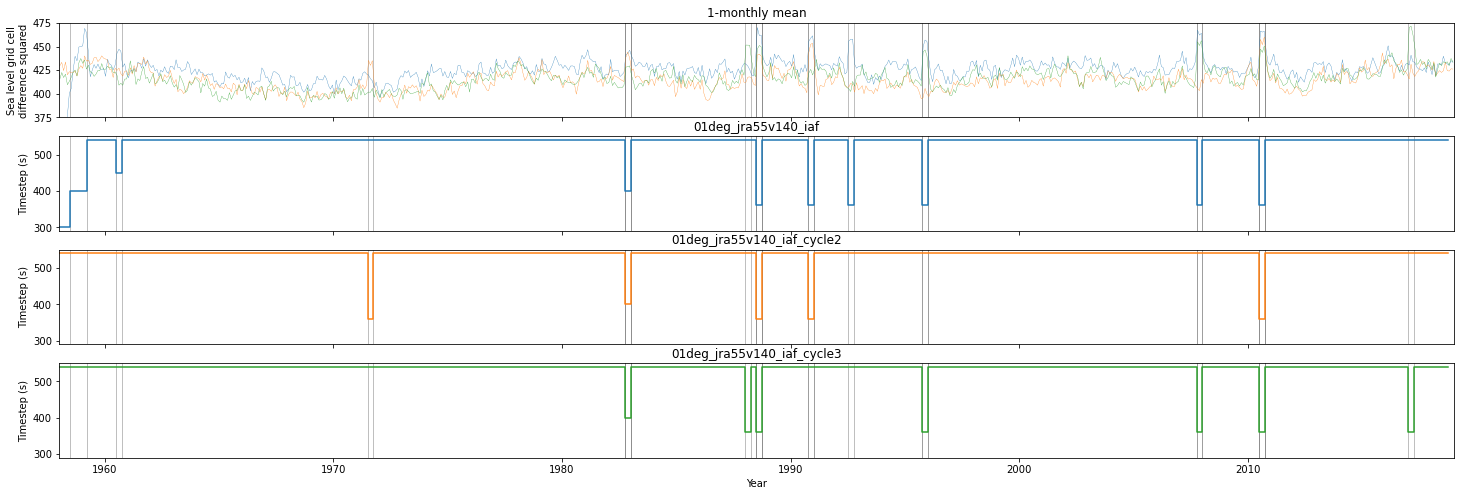

In [32]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # default color cycle
changedates = {k:[v['Run start'][i+1] for i in changeidx[k]] for k,v in alldata.items()}
dates = {k:v['Run start'] for k,v in alldata.items()}
timesteps = {k:v['Timestep (s)'] for k,v in alldata.items()}
# dates = {k:v.append(v[-1]) for k,v in dates.items()}
# timesteps = {k:v.append(v[-1]) for k,v in timesteps.items()}
plt.figure(figsize=(25,8))

for k,v in sea_levels_diffsq_sum.items():
    for p in range(1, 5):
        plt.subplot(4,1,p)
        for idx in changedates[k]:
    #         plt.axvline(idx, ymin=i*0.05, ymax=(i+0.7)*0.05, color=colors[i], linewidth=3)
            plt.axvline(idx, ymin=0, ymax=1, color='gray', linewidth=.5)

plt.subplot(4,1,1)

for i, (k,v) in enumerate(sea_levels_diffsq_sum.items()):
#     for idx in changedates[k]:
# #         plt.axvline(idx, ymin=i*0.05, ymax=(i+0.7)*0.05, color=colors[i], linewidth=3)
#         plt.axvline(idx, ymin=0, ymax=1, color='k', linewidth=1)
    v.plot(label=k, linewidth=0.3, color=colors[i])
#     plt.plot(dates[k], timesteps[k], color=colors[i], drawstyle='steps-post')
#     plt.legend()
    plt.ylabel("Sea level grid cell\ndifference squared")
#     plt.xlim(['1958-01-01', '2019-01-01'])
    plt.ylim([375, 475])
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.xlabel('')
    plt.xlim([datetime.date(1958, 1, 1), datetime.date(2019, 1, 1)])
    xaxlim = plt.gca().get_xlim()
    plt.title(' '.join([frequency.replace(' ','-'), attrs['cell_methods'].split(': ')[1]]))

for i, (k,v) in enumerate(sea_levels_diffsq_sum.items()):
    plt.subplot(4,1,i+2)
    plt.plot(dates[k], timesteps[k], color=colors[i], drawstyle='steps-post')
#     plt.legend()
    plt.title(k)
    plt.ylim([290, 550])
    plt.ylabel("Timestep (s)")
    if i < 2:
        plt.gca().axes.xaxis.set_ticklabels([])
        plt.xlabel('')
    else:
        plt.xlabel('Year')
    plt.xlim(xaxlim)

plt.savefig('_'.join(['ssh_gradient_timeseries', frequency.replace(' ','-'), attrs['cell_methods'].split(': ')[1]])+'.png', dpi=200)

## Velocity at 30m - TODO: finish!
Cycle 1 has daily mean 3d salt, temp, u, v, wt for 1 Jan 1987 to 31 Dec 2018 only

In [12]:
variable = 'u'
frequency = '1 daily'
depth = 30
expts = ['01deg_jra55v140_iaf']

### pre-calculate data

In [ ]:
for yr in range(1987, 1991):
    start_time = '-'.join([str(yr), '01', '01'])
    end_time = '-'.join([str(yr+1), '01', '01'])
    for k in expts:
        p = '_'.join([k, variable, 'sq', 'sum', start_time, end_time])+'.nc'
        if not os.path.exists(p):
            print('calculating and saving', p)
            v = cc.querying.getvar(expt=k, variable=variable, 
                              session=session, frequency=frequency,
                              start_time=start_time,
                              end_time=end_time).sel(time=slice(start_time, end_time)).sel(st_ocean=depth, method='nearest')
            v_sq = v**2
            del v
            v_sq_sum = v_sq.sum('xu_ocean').sum('yu_ocean')
            del v_sq
            v_sq_sum.compute()
            v_sq_sum.to_netcdf(p)
            del v_sq_sum
        else:
            print(' --- skipping', p, '(file exists)')

calculating and saving 01deg_jra55v140_iaf_u_sq_sum_1987-01-01_1988-01-01.nc


distributed.utils - ERROR - "('concatenate-open_dataset-getitem-8151a5e3fc2d432e5f3b543d3791551d', 207, 18, 12)"
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/distributed/utils.py", line 671, in log_errors
    yield
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/distributed/scheduler.py", line 4027, in add_worker
    typename=types[key],
KeyError: "('concatenate-open_dataset-getitem-8151a5e3fc2d432e5f3b543d3791551d', 207, 18, 12)"
distributed.core - ERROR - Exception while handling op register-worker
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/distributed/core.py", line 501, in handle_comm
    result = await result
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/distributed/scheduler.py", line 4027, in add_worker
    typename=types[k

In [ ]:
for yr in range(1987, 1991):
    start_time = '-'.join([str(yr), '01', '01'])
    end_time = '-'.join([str(yr+1), '01', '01'])
    for k in expts:
        p = '_'.join([k, variable, 'diffsq', 'sum', start_time, end_time])+'.nc'
        if not os.path.exists(p):
            print('calculating and saving', p)
            v = cc.querying.getvar(expt=k, variable=variable, 
                              session=session, frequency=frequency,
                              start_time=start_time,
                              end_time=end_time).sel(time=slice(start_time, end_time)).sel(st_ocean=depth, method='nearest')
            v_xdiff = v.diff('xu_ocean')
            v_ydiff = v.diff('yu_ocean')
            del v
            v_diffsq = v_xdiff.isel(yu_ocean=slice(0, -1))**2 \
                             + v_ydiff.isel(xu_ocean=slice(0, -1))**2
            del v_xdiff
            del v_ydiff
            v_diffsq_sum = v_diffsq.sum('xu_ocean').sum('yu_ocean')
            del v_diffsq
            v_diffsq_sum.compute()
            v_diffsq_sum.to_netcdf(p)
            del v_diffsq_sum
        else:
            print(' --- skipping', p, '(file exists)')

 --- skipping 01deg_jra55v140_iaf_u_diffsq_sum_1987-01-01_1988-01-01.nc (file exists)
calculating and saving 01deg_jra55v140_iaf_u_diffsq_sum_1988-01-01_1989-01-01.nc


distributed.utils - ERROR - "('concatenate-open_dataset-getitem-a9bb93e262e8c6ddc375e167db50e7f2', 133, 19, 6)"
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/distributed/utils.py", line 671, in log_errors
    yield
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/distributed/scheduler.py", line 4027, in add_worker
    typename=types[key],
KeyError: "('concatenate-open_dataset-getitem-a9bb93e262e8c6ddc375e167db50e7f2', 133, 19, 6)"
distributed.core - ERROR - Exception while handling op register-worker
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/distributed/core.py", line 501, in handle_comm
    result = await result
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/distributed/scheduler.py", line 4027, in add_worker
    typename=types[key

### load pre-calculated data

In [17]:
v_diffsq_sum = dict()
for k in expts:
    dsets = list()
    prefix = '_'.join([k, variable, 'diffsq', 'sum'])
    files = glob(prefix+'_*.nc')
    files.sort()
    for f in files:
        # need to slice time, as some files are longer than they should be
        fdates = f[len(prefix):].split('_')[1:]
        timeslice = slice(fdates[0], fdates[1].split('.')[0])
        ds = xr.open_dataset(f)[variable]
        ds = ds.sel(time=timeslice)
# TODO: print warning if ds is all nans - not sure if either of these tests works
        if ds.sum().data == 0:
            print('rm', f)
        if len(ds.dropna('time')) == 0:
            print('rm', f)
        dsets.append(ds)
    v_diffsq_sum[k] = xr.concat(dsets, 'time')

distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


## OLD STUFF - IGNORE

In [30]:
start_time = '1958-01-01'
start_time = '2018-01-01'
end_time = '2019-01-01'
variable = 'sea_level'
sea_levels = { k: cc.querying.getvar(expt=k, variable=variable, 
                          session=session, frequency='1 daily',
                          start_time=start_time,
#  dd                         start_time='1958-01-01 00:00:00', 
                          end_time=end_time) for k in expts }

In [21]:
sea_levels_xdiff = { k:a.diff('xt_ocean') for (k, a) in sea_levels.items() }

In [22]:
sea_levels_ydiff = { k:a.diff('yt_ocean') for (k, a) in sea_levels.items() }

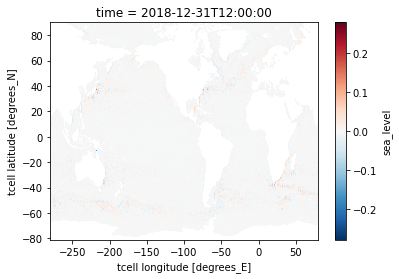

In [23]:
sea_levels_xdiff['01deg_jra55v140_iaf'].isel(time=-1).plot()

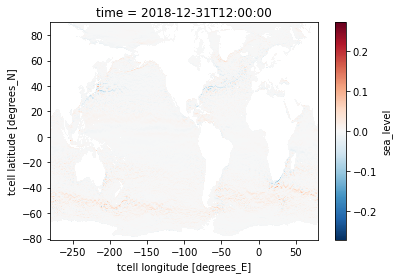

In [24]:
sea_levels_ydiff['01deg_jra55v140_iaf'].isel(time=-1).plot()

In [25]:
sea_levels_diffsq = { k:(sea_levels_xdiff[k].isel(yt_ocean=slice(0, -1))**2 \
                       + sea_levels_ydiff[k].isel(xt_ocean=slice(0, -1))**2) for k in sea_levels }

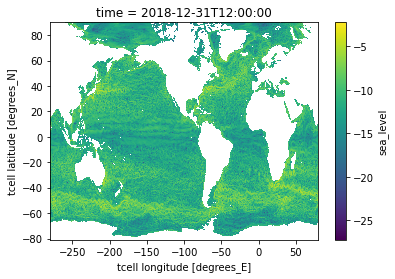

In [28]:
np.log(sea_levels_diffsq['01deg_jra55v140_iaf'].isel(time=-1)).plot()

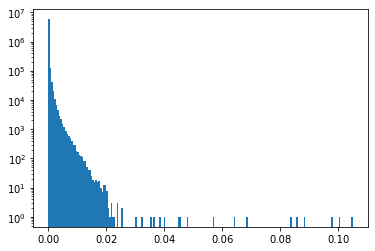

In [27]:
plt.hist(np.ma.ravel(sea_levels_diffsq['01deg_jra55v140_iaf'].isel(time=-1)), bins=200)
plt.yscale('log', nonpositive='clip')


In [29]:
sea_levels_diffsq_sum = { k:a.sum('xt_ocean').sum('yt_ocean') for (k, a) in sea_levels_diffsq.items() }

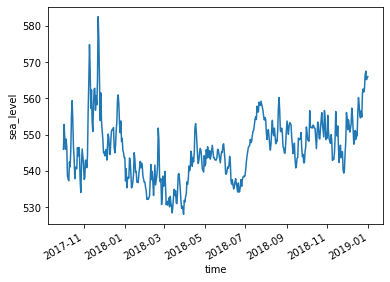

In [33]:
sea_levels_diffsq_sum['01deg_jra55v140_iaf'].plot()

In [39]:
sea_levels_diffsq_sum_old = sea_levels_diffsq_sum

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


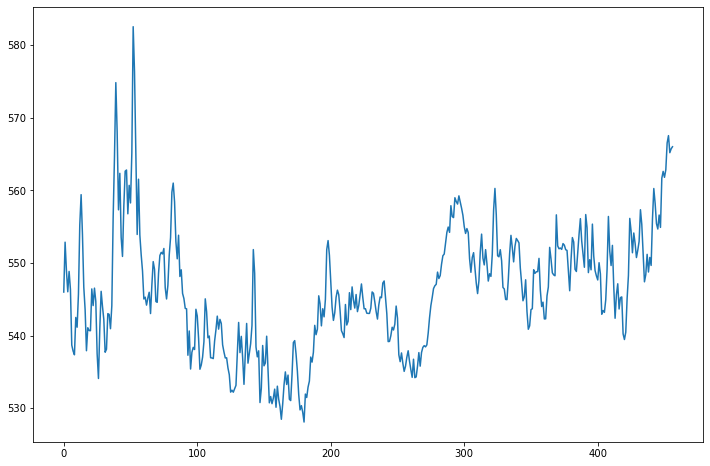

In [37]:
plt.figure(figsize=(12,8))
for k,v in sea_levels_diffsq_sum.items():
    plt.plot(v, label=k)
    break

In [34]:
sea_levels_diffsq_sum['01deg_jra55v140_iaf']

<xarray.DataArray 'sea_level' (time: 457)>
dask.array<sum-aggregate, shape=(457,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2017-10-01T12:00:00 ... 2018-12-31T12:00:00

In [32]:
for k, a in sea_levels_diffsq_sum.items():
    p = '_'.join([k, variable, start_time, end_time])+'.nc'
    if not os.path.exists(p):
        print('calculating and saving', p)
        a.to_netcdf(p)
    else:
        print(' --- loading pre-calculated data from', p)
        sea_levels_diffsq_sum[k] = xr.open_dataset(p)

01deg_jra55v140_iaf_sea_levels_diffsq_sum_2018-01-01_2019-01-01.nc
saving 01deg_jra55v140_iaf_sea_levels_diffsq_sum_2018-01-01_2019-01-01.nc
01deg_jra55v140_iaf_cycle2_sea_levels_diffsq_sum_2018-01-01_2019-01-01.nc
saving 01deg_jra55v140_iaf_cycle2_sea_levels_diffsq_sum_2018-01-01_2019-01-01.nc
01deg_jra55v140_iaf_cycle3_sea_levels_diffsq_sum_2018-01-01_2019-01-01.nc
saving 01deg_jra55v140_iaf_cycle3_sea_levels_diffsq_sum_2018-01-01_2019-01-01.nc


In [16]:
sea_levels_xdiff

{'01deg_jra55v140_iaf': <xarray.DataArray 'sea_level' (time: 457, yt_ocean: 2700, xt_ocean: 3599)>
 dask.array<sub, shape=(457, 2700, 3599), dtype=float32, chunksize=(1, 540, 719), chunktype=numpy.ndarray>
 Coordinates:
   * xt_ocean  (xt_ocean) float64 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
   * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
   * time      (time) datetime64[ns] 2017-10-01T12:00:00 ... 2018-12-31T12:00:00}

In [14]:
sea_levels_ydiff

{'01deg_jra55v140_iaf': <xarray.DataArray 'sea_level' (time: 22280, yt_ocean: 2700, xt_ocean: 3601)>
 dask.array<sub, shape=(22280, 2700, 3601), dtype=float32, chunksize=(1, 539, 720), chunktype=numpy.ndarray>
 Coordinates:
   * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95 -279.9
   * yt_ocean  (yt_ocean) float64 -81.07 -81.02 -80.98 ... 89.94 89.98 89.98
   * time      (time) datetime64[ns] 1958-01-01T12:00:00 ... 2018-12-31T12:00:00}

In [18]:
sea_levels_diffsq

{'01deg_jra55v140_iaf': <xarray.DataArray 'sea_level' (time: 22280, yt_ocean: 2700, xt_ocean: 3600)>
 dask.array<getitem, shape=(22280, 2700, 3600), dtype=float32, chunksize=(1, 540, 719), chunktype=numpy.ndarray>
 Coordinates:
   * xt_ocean  (xt_ocean) float64 -279.8 -279.7 -279.6 ... 79.85 79.95 -279.9
   * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
   * time      (time) datetime64[ns] 1958-01-01T12:00:00 ... 2018-12-31T12:00:00}

In [22]:
sea_levels_diffsq

{'01deg_jra55v140_iaf': <xarray.DataArray 'sea_level' (time: 22280, yt_ocean: 2700, xt_ocean: 3600)>
 dask.array<pow, shape=(22280, 2700, 3600), dtype=float32, chunksize=(1, 539, 720), chunktype=numpy.ndarray>
 Coordinates:
   * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
   * yt_ocean  (yt_ocean) float64 -81.07 -81.02 -80.98 ... 89.94 89.98 89.98
   * time      (time) datetime64[ns] 1958-01-01T12:00:00 ... 2018-12-31T12:00:00}